<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
Missing values:
 target    0
text      0
dtype: int64

Number of duplicates: 403

Number of duplicates after removal: 0

New shape of DataFrame: (5169, 2)

Target value counts:
 target
0    4516
1     653
Name: count, dtype: int64


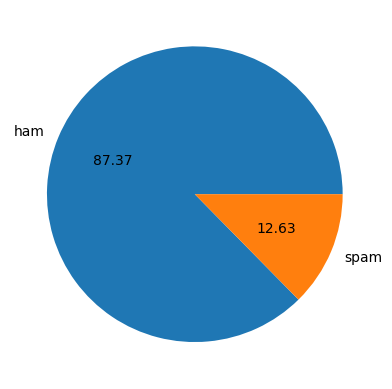

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Description of engineered features for Ham (0) and Spam (1):
       num_characters                                                    \
                count        mean        std   min    25%    50%    75%   
target                                                                    
0              4516.0   70.459256  56.358207   2.0   34.0   52.0   90.0   
1               653.0  137.891271  30.137753  13.0  132.0  149.0  157.0   

              num_words             ...              num_sentences            \
          max     count       mean  ...   75%    max         count      mean   
target                              ...                                        
0       910.0    4516.0  17.123782  ...  22.0  220.0        4516.0  1.820195   
1       224.0     653.0  27.667688  ...  32.0   46.0         653.0  2.970904   

                                            
             std  min  25%  50%  75%   max  
target                                      
0       1.383657  1.0  1.0

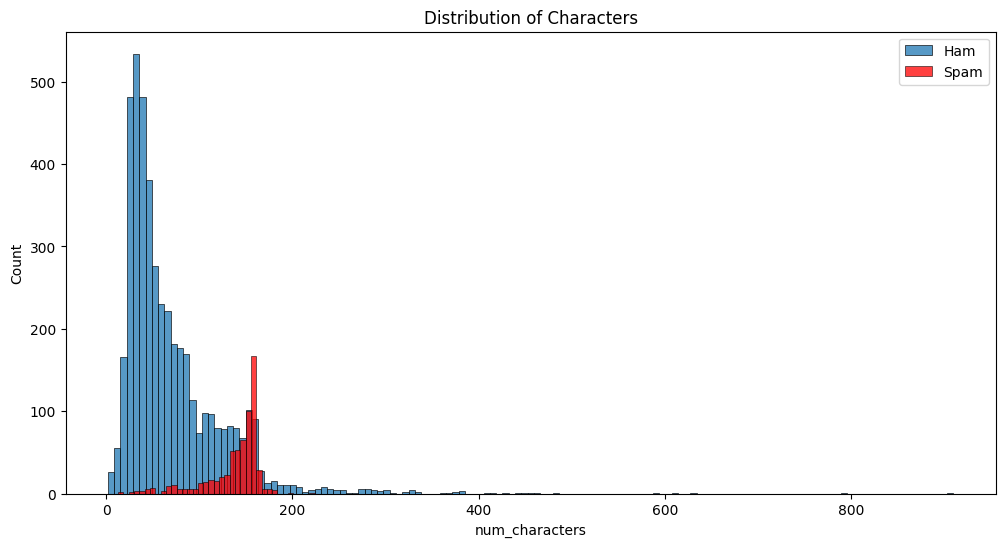

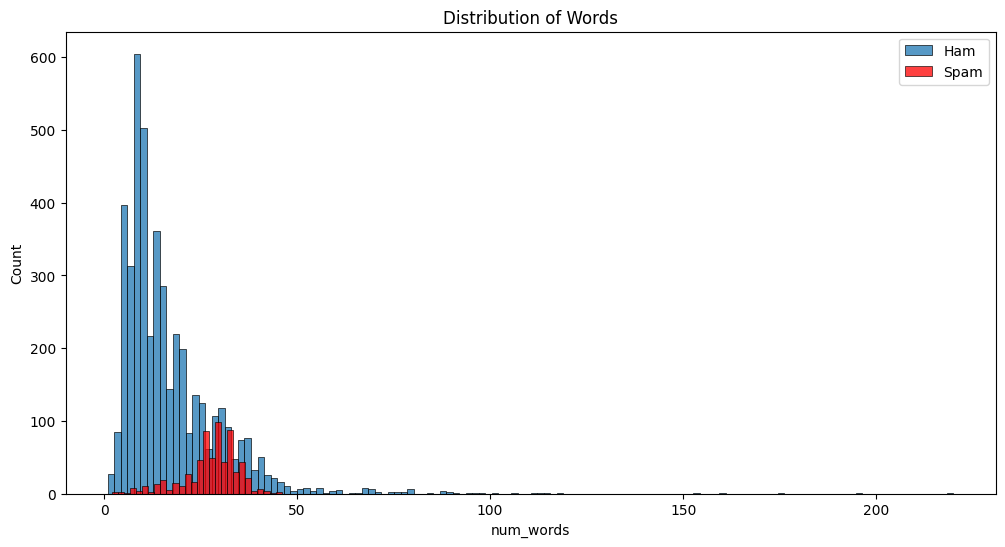

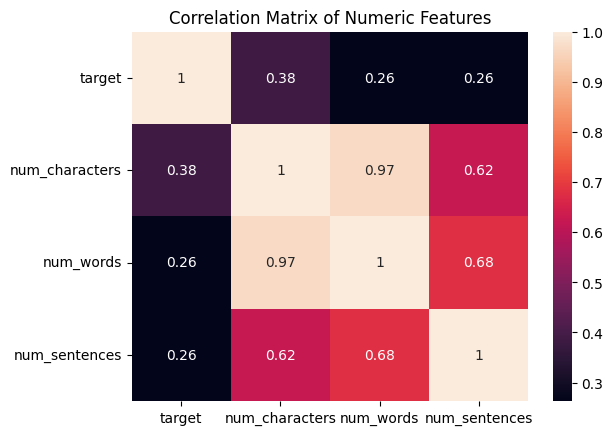

Original: I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
Transformed: gon na home soon want talk stuff anymor tonight k cri enough today


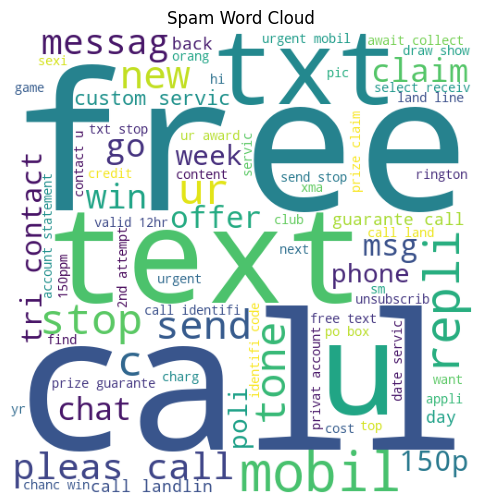

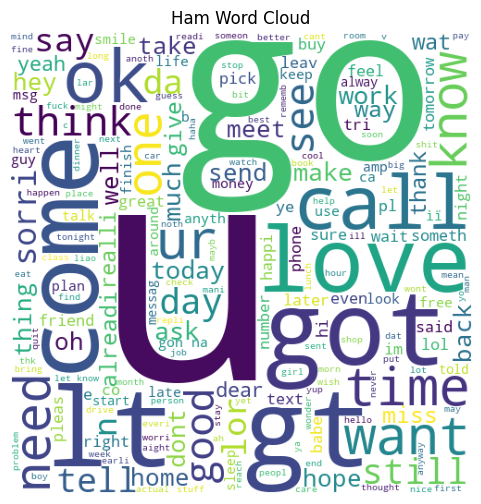

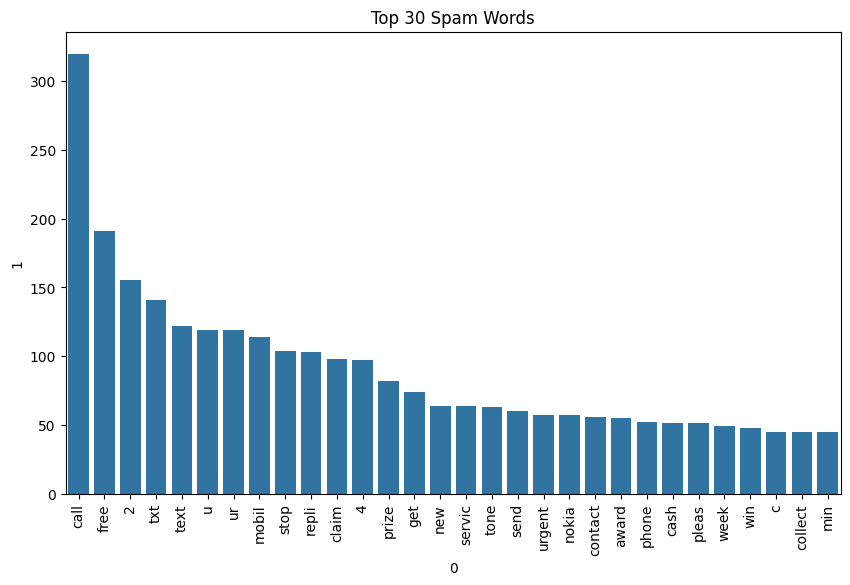

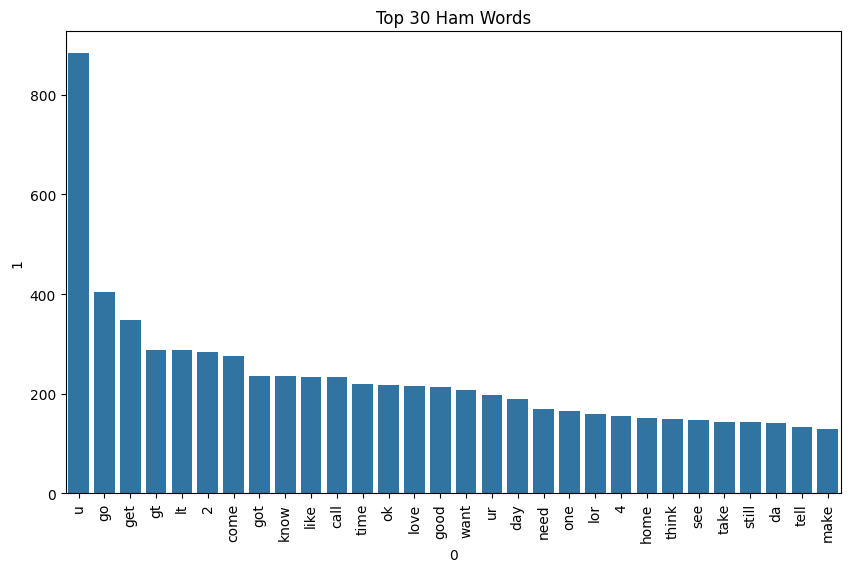

Multinomial Naive Bayes Results:
Accuracy: 0.9709864603481625
Confusion Matrix:
 [[896   0]
 [ 30 108]]
Precision: 1.0

Model and vectorizer have been saved successfully!


In [57]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import pickle

# Cell 2: Load Data
# Make sure to upload your 'spam.csv' file
df = pd.read_csv("spam.csv", encoding='latin1')

# --- 1. Data Cleaning ---

# Cell 3: Initial Data Info
df.info()

# Cell 4: Drop Unnecessary Columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Cell 5: Rename Columns
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

# Cell 6: Label Encoding
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

# Cell 7: Check for Missing and Duplicate Values
print("Missing values:\n", df.isnull().sum())
print("\nNumber of duplicates:", df.duplicated().sum())

# Cell 8: Remove Duplicates
df = df.drop_duplicates(keep='first')
print("\nNumber of duplicates after removal:", df.duplicated().sum())
print("\nNew shape of DataFrame:", df.shape)

# --- 2. Exploratory Data Analysis (EDA) ---

# Cell 9: Target Variable Distribution
print("\nTarget value counts:\n", df['target'].value_counts())
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

# Cell 10: Download NLTK Data (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')

# Cell 11: Feature Engineering
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Cell 12: Describe Engineered Features
print("\nDescription of engineered features for Ham (0) and Spam (1):")
print(df[['target', 'num_characters', 'num_words', 'num_sentences']].groupby('target').describe())

# Cell 13: Histograms for Engineered Features
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_characters'], label='Ham')
sns.histplot(df[df['target'] == 1]['num_characters'], color='red', label='Spam')
plt.legend()
plt.title('Distribution of Characters')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_words'], label='Ham')
sns.histplot(df[df['target'] == 1]['num_words'], color='red', label='Spam')
plt.legend()
plt.title('Distribution of Words')
plt.show()

# Cell 14: Correlation Heatmap
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# --- 3. Data Preprocessing ---

# Cell 15: Text Transformation Function
ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

def transform_text(text):
    text = text.lower()  # Lowercasing
    text = nltk.word_tokenize(text)  # Tokenization

    # Removing special characters and keeping alphanumeric words
    y = [i for i in text if i.isalnum()]

    # Removing stop words and punctuation
    text = [i for i in y if i not in stopwords_english and i not in string.punctuation]

    # Stemming
    y = [ps.stem(i) for i in text]

    return " ".join(y)

# Cell 16: Test the function
sample_text = "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
print("Original:", sample_text)
print("Transformed:", transform_text(sample_text))

# Cell 17: Apply Transformation to DataFrame
df['transformed_text'] = df['text'].apply(transform_text)

# Cell 18: Generate and Display Spam WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_corpus = " ".join(df[df['target'] == 1]['transformed_text'])
if spam_corpus:
    spam_wc = wc.generate(spam_corpus)
    plt.figure(figsize=(15, 6))
    plt.imshow(spam_wc)
    plt.title('Spam Word Cloud')
    plt.axis('off')
    plt.show()
else:
    print("No spam words to generate a word cloud.")

# Cell 19: Generate and Display Ham WordCloud
ham_corpus = " ".join(df[df['target'] == 0]['transformed_text'])
if ham_corpus:
    ham_wc = wc.generate(ham_corpus)
    plt.figure(figsize=(15, 6))
    plt.imshow(ham_wc)
    plt.title('Ham Word Cloud')
    plt.axis('off')
    plt.show()
else:
    print("No ham words to generate a word cloud.")
    
# Cell 20: Top 30 Spam Words Bar Plot
spam_words = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_words.append(word)

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(Counter(spam_words).most_common(30))[0], y=pd.DataFrame(Counter(spam_words).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.title('Top 30 Spam Words')
plt.show()

# Cell 21: Top 30 Ham Words Bar Plot
ham_words = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_words.append(word)

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(Counter(ham_words).most_common(30))[0], y=pd.DataFrame(Counter(ham_words).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.title('Top 30 Ham Words')
plt.show()


# --- 4. Model Building ---

# Cell 22: Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# Cell 23: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Cell 24: Train and Evaluate Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print("Multinomial Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

# --- 5. Exporting the Model and Vectorizer ---

# Cell 25: Save the model and vectorizer to disk
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))
print("\nModel and vectorizer have been saved successfully!")